# Experiments with real data (Heart Disease)

https://archive.ics.uci.edu/dataset/45/heart+disease

## Requirements

In [28]:
import os, pickle
import polars as pl
import numpy as np
from BigEDA.descriptive import outliers_table, summary
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix

current_path = os.getcwd()
data_path = os.path.join(current_path, '..', '..', '..', 'data')
data_filename = 'uci_heart_disease_processed.pkl'
data_file_path = os.path.join(data_path, data_filename)

## Data exploration


### Conceptual description

| Variable     | Descripción                                                                                           | Tipo                         | Valores                                                                                  |
|--------------|--------------------------------------------------------------------------------------------------------|------------------------------|--------------------------------------------------------------------------------------------------|
| age          | Edad del paciente en años al momento del estudio.                                                      | Numérica (entera)            | 29 – 77                                                                                  |
| sex          | Sexo del paciente.                                                                                     | Binaria                      | `male (1)`, `female (0)`                                                                 |
| cp           | Tipo de dolor torácico experimentado.                                                                 | Categórica nominal           | `typical angina (1)`, `atypical angina (2)`, `non-anginal pain (3)`, `asymptomatic (4)`    |
| trestbps     | Presión arterial en reposo (mm Hg) medida al ingreso hospitalario.                                     | Numérica (entera)            | 94 – 200                                                                                  |
| chol         | Colesterol sérico total (mg/dl).                                                                      | Numérica (entera)            | 126 – 564                                                                                 |
| fbs          | Azúcar en ayunas mayor a 120 mg/dl.                                                                  | Binaria                      | `true (1)`, `false (0)`                                                                   |
| restecg      | Resultados del electrocardiograma (ECG) en reposo.                                                    | Categórica nominal           | `normal (0)`, `ST-T wave abnormality (1)`, `left ventricular hypertrophy (2)`              |
| thalach      | Frecuencia cardíaca máxima alcanzada.                                                                 | Numérica (entera)            | 71 – 202                                                                                  |
| exang        | Angina inducida por ejercicio.                                                                        | Binaria                      | `yes (1)`, `no (0)`                                                                       |
| oldpeak      | Depresión del segmento ST inducida por ejercicio relativa al reposo.                                   | Numérica (continua)          | 0 – 6.2                                                                                    |
| slope        | Pendiente del segmento ST al ejercicio máximo.                                                        | Categórica ordinal           | `upsloping (1)`, `flat (2)`, `downsloping (3)`                                             |
| ca           | Número de vasos principales (0–3) coloreados por fluoroscopia.                                        | Numérica (entera)            | 0 – 3                                                                                      |
| thal         | Resultado del test de talio.                                                                          | Categórica nominal           | `normal (3)`, `fixed defect (6)`, `reversible defect (7)`                                   |
| num (target) | Diagnóstico de enfermedad cardíaca.                                                                  | Binaria (redefinida)         | `ausencia (0)`, `presencia (1)` (originalmente 0 = ausencia, 1–4 = presencia leve a grave) |


### Data reading

In [29]:
with open(data_file_path, "rb") as f:
    loaded_data = pickle.load(f)

X, y, p1, p2, p3, encoding, quant_predictors, binary_predictors, multiclass_predictors = loaded_data.values()

n_clusters = len(y.unique())

### Data view

In [30]:
X.head()

age,trestbps,chol,thalach,oldpeak,ca,sex,fbs,exang,cp,restecg,slope,thal
i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,f64
63,145,233,150,2.3,0.0,1,1,0,1,2,3,6.0
67,160,286,108,1.5,3.0,1,0,1,4,2,2,3.0
67,120,229,129,2.6,2.0,1,0,1,4,2,2,7.0
37,130,250,187,3.5,0.0,1,0,0,3,0,3,3.0
41,130,204,172,1.4,0.0,0,0,0,2,2,1,3.0


In [31]:
y.head(5)

num
i64
0
1
1
0
0


In [32]:
print(p1, p2, p3)

6 3 4


In [33]:
encoding

{'num': {2: 1, 3: 1, 4: 1}}

In [34]:
quant_predictors

['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

In [35]:
binary_predictors

['sex', 'fbs', 'exang']

In [36]:
multiclass_predictors

['cp', 'restecg', 'slope', 'thal']

### Data description

In [37]:
X.describe()

statistic,age,trestbps,chol,thalach,oldpeak,ca,sex,fbs,exang,cp,restecg,slope,thal
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",297.0,297.0,297.0,297.0,297.0,297.0,297.0,297.0,297.0,297.0,297.0,297.0,297.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",54.542088,131.693603,247.350168,149.599327,1.055556,0.676768,0.676768,0.144781,0.326599,3.158249,0.996633,1.602694,4.73064
"""std""",9.049736,17.762806,51.997583,22.941562,1.166123,0.938965,0.4685,0.352474,0.469761,0.964859,0.994914,0.618187,1.938629
"""min""",29.0,94.0,126.0,71.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0
"""25%""",48.0,120.0,211.0,133.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,3.0
"""50%""",56.0,130.0,243.0,153.0,0.8,0.0,1.0,0.0,0.0,3.0,1.0,2.0,3.0
"""75%""",61.0,140.0,276.0,166.0,1.6,1.0,1.0,0.0,1.0,4.0,2.0,2.0,7.0
"""max""",77.0,200.0,564.0,202.0,6.2,3.0,1.0,1.0,1.0,4.0,2.0,3.0,7.0


In [38]:
y.describe()

statistic,num
str,f64
"""count""",303.0
"""null_count""",0.0
"""mean""",0.458746
"""std""",0.49912
"""min""",0.0
"""25%""",0.0
"""50%""",0.0
"""75%""",1.0
"""max""",1.0


In [39]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = counts/len(y)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.5412541254125413, 1: 0.45874587458745875}


In [40]:
outliers_df = outliers_table(X, auto=False, col_names=quant_predictors, h=1.5)
outliers_df

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""age""",28.5,80.5,0,297,0.0,1.0
"""trestbps""",90.0,170.0,9,288,0.030303,0.969697
"""chol""",113.5,373.5,5,292,0.016835,0.983165
"""thalach""",83.5,215.5,1,296,0.003367,0.996633
"""oldpeak""",-2.4,4.0,5,292,0.016835,0.983165
"""ca""",-1.5,2.5,20,277,0.06734,0.93266


In [41]:
outliers_df['prop_outliers'].mean()

0.02244668911335578

In [44]:
quant_summary, cat_summary = summary(df=X, quant_col_names = quant_predictors, cat_col_names = binary_predictors + multiclass_predictors)

In [46]:
quant_summary

,n_unique,perc_nan,mean,std,min,Q10,Q25,median,Q75,Q90,max,kurtosis,skew,prop_outliers
age,41,0.0,54.542088,9.049736,29.0,42.0,48.0,56.0,61.0,66.0,77.0,2.466854,-0.218663,0.0
trestbps,50,0.0,131.693603,17.762806,94.0,110.0,120.0,130.0,140.0,152.0,200.0,3.781192,0.696529,0.030303
chol,152,0.0,247.350168,51.997583,126.0,192.0,211.0,243.0,276.0,309.0,564.0,7.349479,1.112441,0.016835
thalach,91,0.0,149.599327,22.941562,71.0,116.0,133.0,153.0,166.0,177.0,202.0,2.928885,-0.533826,0.003367
oldpeak,40,0.0,1.055556,1.166123,0.0,0.0,0.0,0.8,1.6,2.8,6.2,4.46552,1.240824,0.016835
ca,4,0.0,0.676768,0.938965,0.0,0.0,0.0,0.0,1.0,2.0,3.0,3.211157,1.173582,0.06734


In [47]:
cat_summary

,n_unique,perc_nan,mode
sex,2,0.0,1
fbs,2,0.0,0
exang,2,0.0,0
cp,4,0.0,4
restecg,3,0.0,0
slope,3,0.0,1
thal,3,0.0,3.0


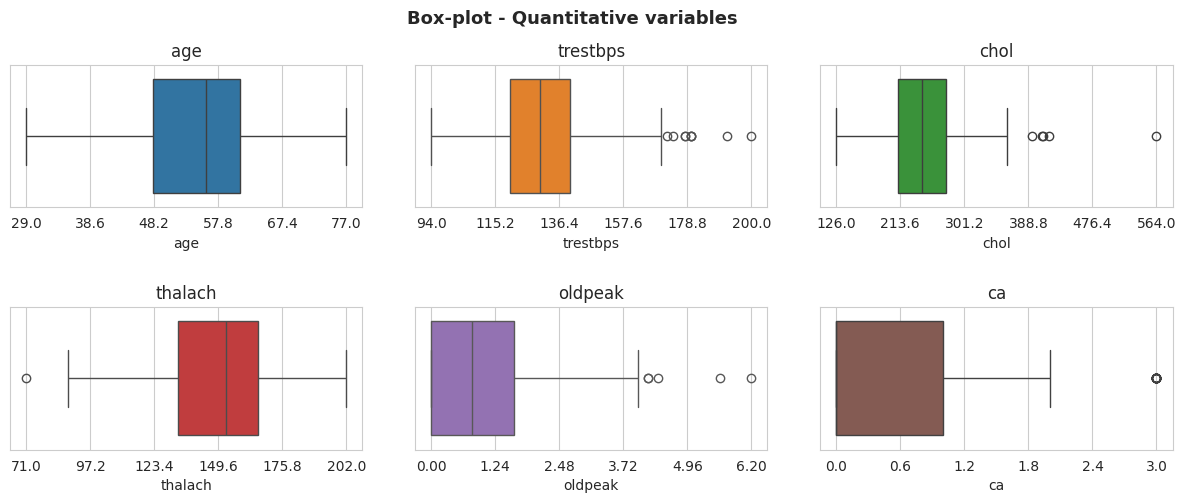

In [50]:
# Boxplot after outliers contamination
boxplot_matrix(X, 
               n_cols=3, 
               title='Box-plot - Quantitative variables', 
               figsize=(15,5), 
               quant_col_names=quant_predictors, 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

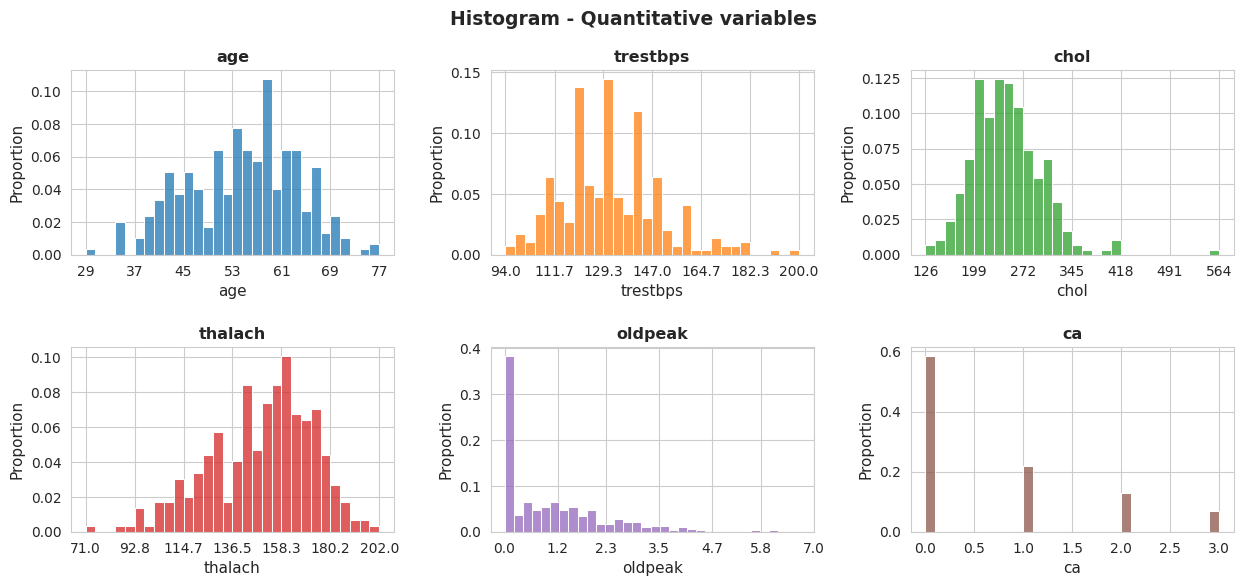

In [52]:
# Histogram
histogram_matrix(df=X, bins=30, n_cols=3, title='Histogram - Quantitative variables', 
                 figsize=(15,6), quant_col_names=quant_predictors, 
                 n_xticks=7, title_fontsize=13.5, 
                 subtitles_fontsize=11.5, save=False, file_name='', x_rotation=0, title_height=0.98,
                 style='whitegrid', hspace=0.5, wspace=0.3, n_round_xticks=1)

In [ ]:
# Barplot
barplot_matrix(df=X_pl, n_cols=2, title='Barplot - Categorical variables', 
                 figsize=(8,4), cat_col_names=['X5', 'X6', 'X7', 'X8'], 
                 title_fontsize=13, subtitles_fontsize=11, 
                 save=False, file_name='', x_rotation=0, title_height=0.99,
                 style='whitegrid', hspace=0.75, wspace=0.4, title_weight='bold', bar_width=0.35,
                 ylabel_size=10, xlabel_size=9, xticks_size=10)

In [ ]:
# Correlation Matrix
X.corr()

In [ ]:
# Correlation Analysis
corr_matrix = X.corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))


## Experiment 1



## Experiment 3



## Experiment 4